In [1]:
%load_ext autoreload
%autoreload 2

# Probabilistyczne Modele Grafowe:
## 9. Aspekty uczenia i ewaluacji Bayesowskich modeli uczenia maszynowego
#### Tomasz Kajdanowicz, Piotr Bielak, Maciej Falkiewicz, Piotr Zieliński
#### Katedra Inteligencji Obliczeniowej - Politechnika Wrocławska

### Prezentacja powstała na podstawie następujących materiałów źródłowych:
- [Christopher M. Bishop.Pattern Recognition and Machine Learning. Springer, 2006](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) Chapter 3.5 The Evidence Approximation
- Notatki autorstwa Johna T. Whelana do kursu [Bayesian Model Evaluation](https://ccrgpages.rit.edu/~whelan/courses/2017_1sp_STAT_489/) - [Part Two: Bayesian Model Evaluation](https://ccrgpages.rit.edu/~whelan/courses/2017_1sp_STAT_489/notes_models.pdf)
- Blog Post autorstwa [Eduardo Coronado Sroka](https://ecoronado92.github.io/) - [Evaluating Bayesian Mixed Models in R/Python](https://towardsdatascience.com/evaluating-bayesian-mixed-models-in-r-python-27d344a03016)
- Notatki autorstwa Davida M. Bleia do kursu [Advanced Methods in Probabilistic Modeling](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/) - [Posterior Predictive Checks](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/ppc.pdf)

### Spis Treści
- Wstęp
- Dane i modele
- Ewaluacja modelu
   - Posterior Predictive Checks:
      - Rozkład posterior
      - Statystyki testowe
      - Probability Integral Transform
- Porównywanie modeli
   - Bayes factors
   - Expected Log Predictive Density

# Wstęp

### Aspekty uczenia i ewaluacji Bayesowskich modeli
- Ewaluacja modelu -- Model Checking
- Porównywanie modeli -- Model Comparision
- Wybór hiper-parametrów (poza zakresem dzisiejszego wykładu)
   - Empirical Bayes / Evidence Approximation / Evidence Maximization
   - Expectation-Maximization
   - Aproksymacje *evidence* dla konkretnych modeli -- np. Laplace approximation dla Bayesian Linear Regression ze sprzężonymi priorami ([Christopher M. Bishop.Pattern Recognition and Machine Learning. Springer, 2006](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) Section 4.4)

### Modelowanie: Cel
- Osiagniecie jak najlepszych wartosci metryk? NIE
- Zbudowanie modelu, który umozliwi dokladna predykcje *przyszlosci* - tzw, **generalizacja**? TAK, ale nie tylko
- Identyfikacja sytuacji, w ktorych model nie dziala i zrozumienie czemu? TAK
- Zrozumienie analizowanego problemu i dobór odpowuednich narzędzi? TAK

### Modelowanie: Z czego składa się model?
1. **Wstępna wiedza**:
   - *background information* na temat zjawiska - pozwala kwantyfikować przekonanie (prawdopobienstwo) na temat poprawnosci stwierdzenia. Moze sie miedzy innymi wyrazac jako:
      - Wybor parametryczna postać modelu (np. Bayesian Linear Regression) - stąd wiem jak obliczać likelihood, rozkład posterior parametrów, rozkład predykcyjny, itp.
      - Przekonanie co do poprawnosci roznych postaci parametrycznych
      - Przekonanie na temat poprawności rozkładu prior parametrow
   - Rozkład prior dla parametrów modelu
     
     W tym punkcie zawiera się wiedza o parametrycznej postaci priora (rodzina rozkładów) oraz jej konkretnej parametryzacji. Prior może być *informative* bądź *uninformative*. Może tez nie byc pelnoprawnym rozkladem prawdopodobienstwa i wtedy mowimy, ze jest *improper*.
2. **Dane treningowe** na podstawie, których aktualizujemy wstępna wiedze

Koncept *background information* wywodzi sie z prac Richarda Coxa z 1946 roku. Chciał opracować spojny system logicznego wnioskowania. Doszedł do wniosku, ze kazde stwierdzenie ktorego prawdziwosci nie jestesmy w stanie sprawdzic "binarnie" posiada pewien poziom zaufania, ktory je darzymy. Naturalnym okazało sie ujac system w jezyku teorii prawdopobienstwa. Aby jednak zachowac spojnosc nalezy wprowadzic *background information*, które warunkuje wszystkie rozkłady. Albowiem nie ma uniwersalnej miary pewnosci stwierdzeń i kazdy ocenia ja wzgledem swojej wiedzy i doswiadczen.

Ciekawe i przystepne wprowadzenie do tematu mozna znalzc w ksiazce [Sivia, Devinderjit, and John Skilling. Data analysis: a Bayesian tutorial. OUP Oxford, 2006.](http://aprsa.villanova.edu/files/sivia.pdf).

### Model - formalnie
- $I$ - background information
- $\pmb{\theta}$ - parametry modelu
- $M$ - wiedza o rozkładzie prior
- $\mathcal{D}$ - dane

Rozkład posterior parametrów:
$$ p(\pmb{\theta}|\mathcal{D}, M, I) = \frac{p(\mathcal{D}|\pmb{\theta}, I)p(\pmb{\theta}| M, I)}{p(\mathcal{D}|M,I)}$$

Marginalized sampling distribution / *model evidence* / mariginal likelihood:
$$ p(\mathcal{D}|M,I) = \int p(\mathcal{D}|\pmb{\theta}, I)p(\pmb{\theta}| M, I)d\pmb{\theta} $$

Prawdopobienstwo posterior modelu (dla danego background information):
$$ P(M|\mathcal{D}, I) = \frac{p(\mathcal{D}|M,I) P(M|I)}{p(\mathcal{D}|I)} $$

- $P(M|I)$ - zgodnie z dotychczasowa narracja nalezaloby rozumiec ta wartosc jako relatywne przekonanie na temat poprawnosci $M$, nie badzmy jednak zbyt doslowni gdyz:
  
  *Essentially,  all  models  are  wrong,  but  some  are  useful* 
  
  ~George  Box w Box & Draper,Empirical Model-Building and Response Surfaces(Wi-ley.  1987)
- $p(\mathcal{D}|I)$ - ten wyraz jest problematyczny poniewaz aby go obliczyc musimy znac *wszystkie* modele (oznaczmy ich zbiór jako $\{M_i\}$) i ich prawdopobienstwa prior:
   $$ p(\mathcal{D}|I) = \sum p(\mathcal{D}|M_i, I) P(M_i|I) $$

Powrocimy do tych zagadnien w dalszej czesci tego wykladu.

# Dane i modele

### Generowanie danych
Aby przedstawic dzialanie omawianych metod w praktyce, wygenerujemy zbior 100 punktów danych z nastepujacego modelu:

$$ y = 3 - 2.3 x + 1.7 x^2 + 0.8 x^3 -0.3 x^4 + Uniform(-2.5, 2.5)$$

Dopasujemy do nich nastepujace modele:
1. Bayesian Linear Regression z wyrazami $x, x^2, x^3, x^4$ i dopasowaniem hiper-parametrow metoda EM
2. Bayesian Linear Regression z wyrazami $x, x^2, x^3$ i dopasowaniem hiper-parametrow metoda EM
3. Bayesian Linear Regression z wyrazami $x, x^2, x^3, x^4$ i recznie dobranymi hiper-parametrami $\alpha=1$ i $\lambda=0.5$

Dane na osi $x$ zostały wygenerowane tak aby nierownomiernie pokryc zakres.

Przed dopasowaniem modeli zmienne zostaly ustandaryzowane, a wyraz wolny wyderywowany z $y$.

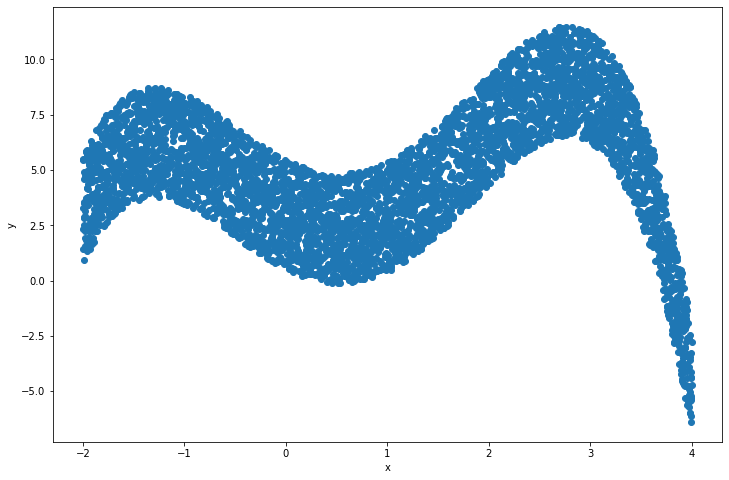

In [2]:
from src.data import sample_data, plot_data
data = sample_data()
plot_data(data)

Nanieśmy wykres funkcji na chmure danych.

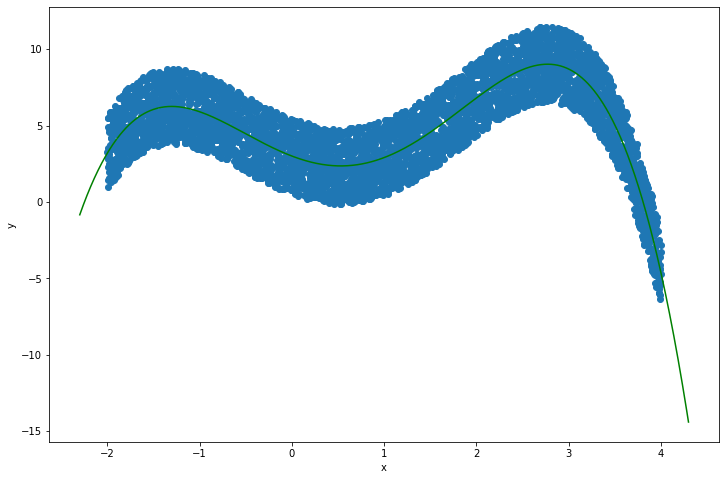

In [3]:
plot_data(data, plot_fun=True)

### Przygotowanie modeli

In [4]:
from src.models import get_model_1, get_model_2, get_model_3

model_1, x_1 = get_model_1(data)
model_2, x_2 = get_model_2(data)
model_3, x_3 = get_model_3(data)

### Model 1

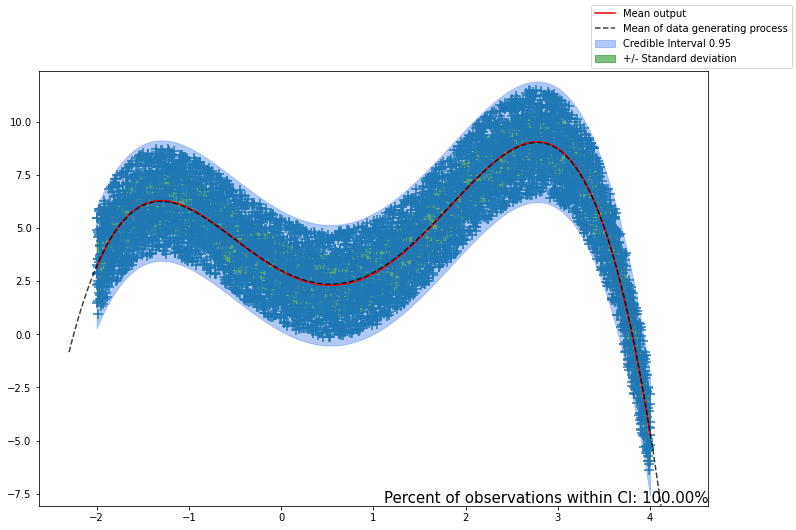

In [5]:
from src.vis import plot_model
from src.data import _data_coef

plot_model(model=model_1, x=x_1, x_org=data[0], y=data[1])

### Model 2

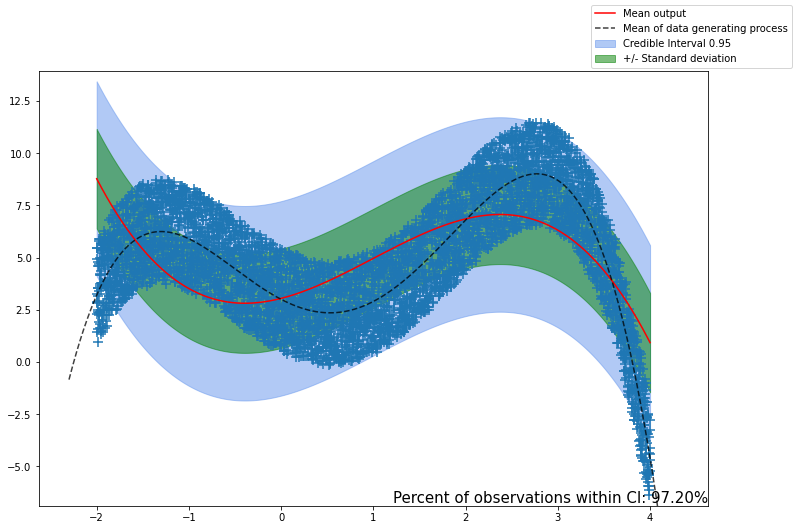

In [6]:
from src.vis import plot_model

plot_model(model=model_2, x=x_2, x_org=data[0], y=data[1])

### Model 3

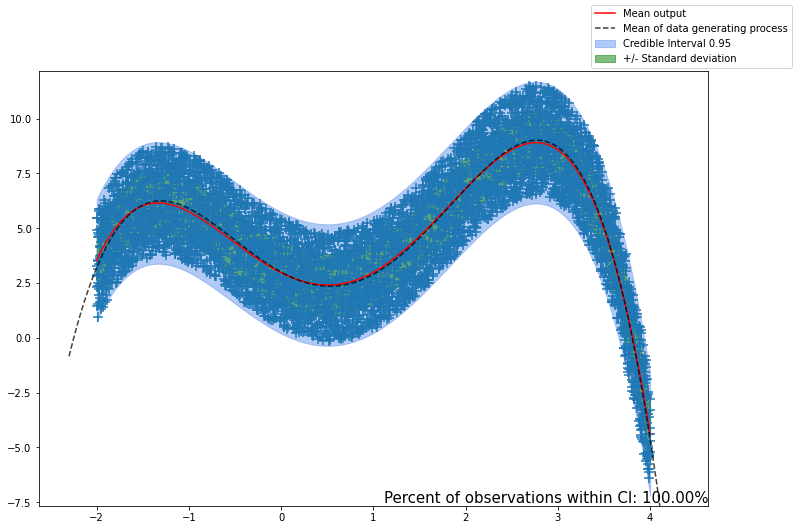

In [7]:
from src.vis import plot_model

plot_model(model=model_3, x=x_3, x_org=data[0], y=data[1])

# Ewaluacja modelu
## Posterior Predictive Checks
### Rozkład posterior

### Klasyczna ewaluacja:
- Obliczenie metryk:
   - klasyfikacja:
      - wszystko na podstawie confusion matrix - brak informacji o niepewnosci modelu
      - ROC / PRC - niepewnosc wylacznie w predykcji, ale nie w parametrach modelu
   - regresja:
      - wszelkie *Error* - jaki dobrać, srednia z danych, brak informacji o niepewnosci modelu
- Q-Q plot dla rezyduów (dla wybranych modeli) - załozenia zadko kiedy sa spelnione
- interwały (zbiory) ufnosci i predykcyjne (dla wybranych modeli) - niepewnosc wylacznie w predykcji, ale nie w parametrach modelu

Aby stosowac dla modeli Bayesowskich nalezy wybrac MAP z rozkładu predykcyjnego / wielokrotnie realizowac rozklad predykcyjny.

### Bayesowska ewaluacja
W centrum Bayesowskiego podejscia do ewaluacji modeli probabilistycznych lezy fakt, ze dane obserwowane (rzeczywiste) powinny byc wysoce prawdopobne w danym modelu dopasowanym na tych danych (badz innej próbki z tego samego procesu generujacego).

Rozkład posterior predictive:

$$ p(\tilde{\mathcal{D}}|\mathcal{D}) = \int p(\tilde{\mathcal{D}}|\pmb{\theta}) p(\pmb{\theta}|\mathcal{D}) d \pmb{\theta}, $$
co w naszej, bardziej bezposredniej notacji zapiszemy jako
$$ p(\tilde{\mathcal{D}}|\mathcal{D}, M, I) = \int p(\tilde{\mathcal{D}}|\pmb{\theta}, I) p(\pmb{\theta}|\mathcal{D}, M, I) d \pmb{\theta}. $$

Ale jak obliczyc ta calke?

- Dla niektorych modeli umiemy ja obliczyc - Bayesian Linear Regression
- Dla pozostałych zamiast probowac to robic, wykorzystamy metode Monte Carlo i dla zadanego rozmiaru próbki $S$ wylosujemy realizacje parametrow z rozkladu posterior, a nastepnie probki z rozkladu predykcyjnego.

### Uwaga

Dotychczas rozwazalismy sytuacje gdy dane $\mathcal{D}$ stanowia nierozerwalny zbiór. Takie podejscie odnajduje zastosowanie gdy chcemy na przyklad estymowac gestosc rozkladu badz wartosc jakiejs statystyki. Tymczasem duzo bardziej jest dla nas interesujace budowanie modeli predykcyjnych, ktore pewnych wartosci cech $X$ sa w stanie zwrocic rozkład predykcyjny na $y$. Zatem mozemy zapisac, ze $\mathcal{D} = (X, y)$.

Dotychczasowe rozwazania nie traca mocy, poniewaz zawsze mozemy potraktowac $X$ jako element warunkujacy i skupic sie z Bayesowskim rozumowaniem na $y$. Na przyklad rozkład posterior predictive przyjmie nastepujaca postac:
$$ p(\tilde{y}|\mathcal{D}) = p(\tilde{y}|X, y) = \int p(\tilde{y}|\pmb{\theta}, X) p(\pmb{\theta}|X, y) d \pmb{\theta}$$

### Graficzne porównanie rozkładu posterior predictive
Jezeli model dobrze opisuje dane, to dla tego samego zestawu cech $X$ powinien generowac $y$ z rozkladu takiego jak obserwowany.

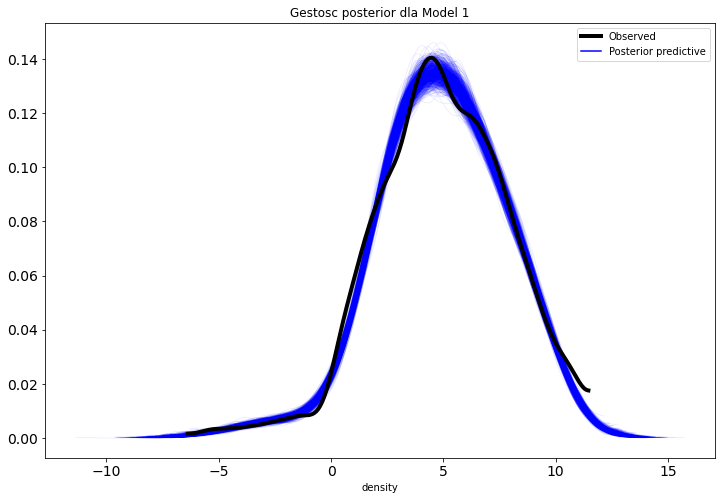

In [8]:
from src.vis import plot_ppc
plot_ppc(model_1.predict(x_1), data[1], title='Gestosc posterior dla Model 1')

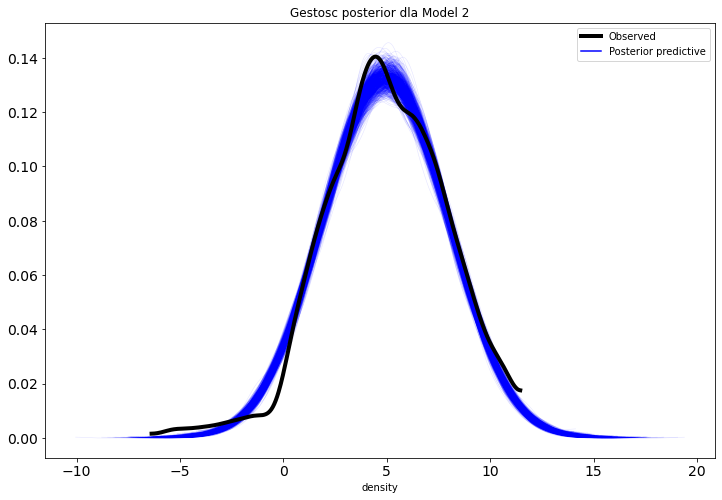

In [9]:
from src.vis import plot_ppc
plot_ppc(model_2.predict(x_2), data[1], title='Gestosc posterior dla Model 2')

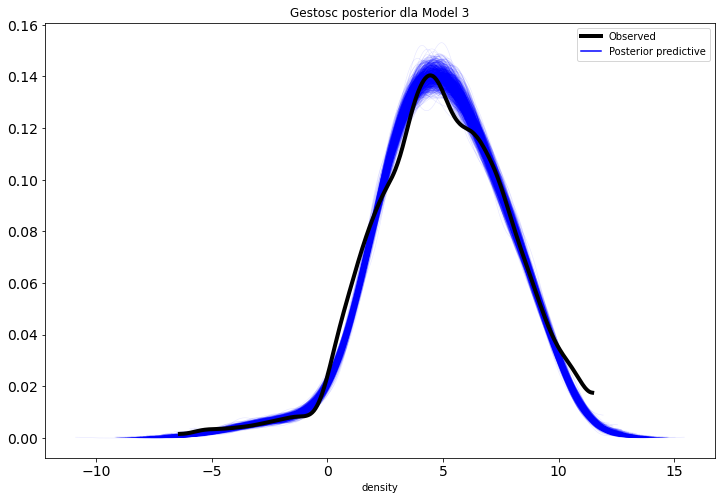

In [10]:
from src.vis import plot_ppc
plot_ppc(model_3.predict(x_3), data[1], title='Gestosc posterior dla Model 3')

# Ewaluacja modelu
## Statystyki testowe

### Statystyki testowe
Graficzne porównanie rozkładów empirycznych daje nam pewna wstepna intuicje na temat dopasowania modelu, ale nie jest mozliwym wyznaczyc granice gdy jest ono zbyt slabe.

W tym celu mozemy wykorzystac statystyki testowe $T(y)|X$. Istnieje pełna dowolnosc w konstruowaniu statystyk testowych, poniewaz niekoniecznie bedzie nas interesowac ich analityczny rozklad. Naturalnym jest skorzystac z typowych statystyk, takich jak:
- srednia
- odchylenie standardowe
- mediana
- skosnosc (skewness)

### Statystyki testowe
Statystyki testowe mozemy wykorzystac na dwa sposoby:
- Graficzne porownanie - dla kazdego elementu probki z rozkladu predykcyjnego obliczamy $T(y)$, nastepnie sprawdzamy jak rozklad wartosci statystyki ma sie do wartosci dla probki obserwowanej
- Bayesian p-values - posiadajac rozklad wartosci statystyki testowej dla rozkladu predykcyjnego mozemy zadac pytanie jakie jest prawdopobienstwo, ze obserwowana wartosc jest wieksza / mniejsza

  "Prawy" ogon:
$$ p_r(\mathcal{D}|M, I) = P(T(\tilde{y}) \geqslant T(y)|X, y, M, I) = \int  P(T(\tilde{y}) \geqslant T(y)|I, \pmb{\theta}) p(\pmb{\theta}|\mathcal{D}, M, I) d \pmb{\theta}$$

  "Lewy" ogon:
$$ p_l(\mathcal{D}|M, I) = P(T(\tilde{y}) \leqslant T(y)|X, y, M, I) = \int  P(T(\tilde{y}) \leqslant T(y)|I, \pmb{\theta}) p(\pmb{\theta}|\mathcal{D}, M, I) d \pmb{\theta}$$

### Statystyki testowe

Ale nas interesuje ekstremum z obu krancow, dlatego wykorzystamy podejscie dla testow dwustronnych (ang. *two tailed*)

$$ p(\mathcal{D}|M, I) = 2 \min (p_r(\mathcal{D}|M, I), p_l(\mathcal{D}|M, I)) $$

Ale nie chcemy obliczac tych skoplikowanych całek (nawet jezeli to mozliwe)! Ponownie wykorzystamy podejscie Monte Carlo.

Pracujac z p-values nalezy pamietac ze:
- Nie istnieje cos takiego jak magiczna wartosc 0.05 (badz inna), na podstawie ktorej absolutnie nalezy odrzucic model / hipoteze.
- Test opiera sie na jakiejs statystyce $T(y)$, jezeli nie jest ona w stanie wlasciwie "ocenic" modelu, to wynik jest bezwartosciowy.
- Jezeli hipoteza / model jest poprawny, to p-values maja rozklad $Uniform(0,1)$, wiec wykonujac wystarczajaco duzo testow trafimy na taki odrzucajacy.
- Aby mowic o pewnym poziomie ufnosci przy wykonywaniu wielu testow nalezy dokonac korekcji (np. Bonferroni correction.)

In [11]:
from numpy import mean, median, std
from scipy.stats import skew

test_statistics = {
    'mean': mean,
    'median': median,
    'std': std,
    'skewness': skew
}

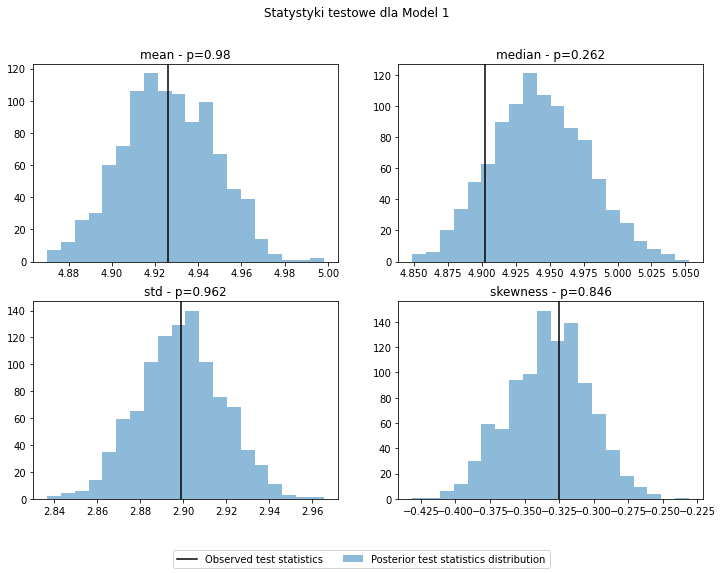

In [12]:
from src.vis import plot_posterior_test_statistics

plot_posterior_test_statistics(
    model_1.predict(x_1),
    data[1],
    test_statistics,
    title='Statystyki testowe dla Model 1'
)

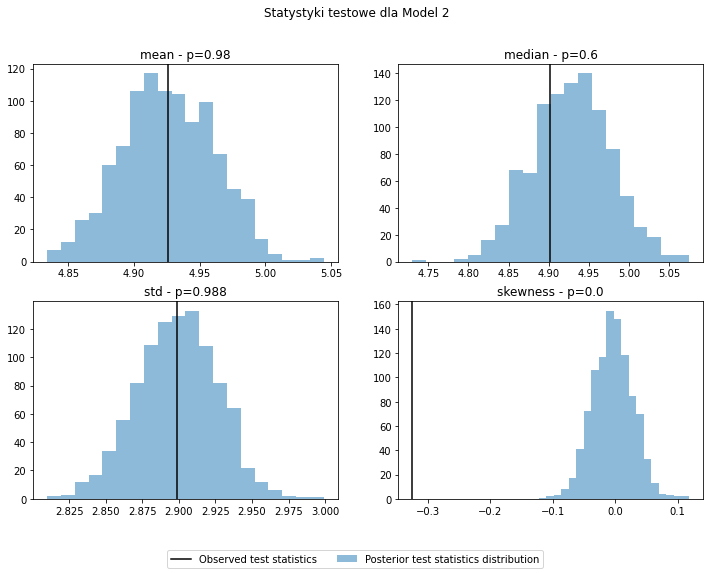

In [13]:
from src.vis import plot_posterior_test_statistics

plot_posterior_test_statistics(
    model_2.predict(x_2),
    data[1],
    test_statistics,
    title='Statystyki testowe dla Model 2'
)

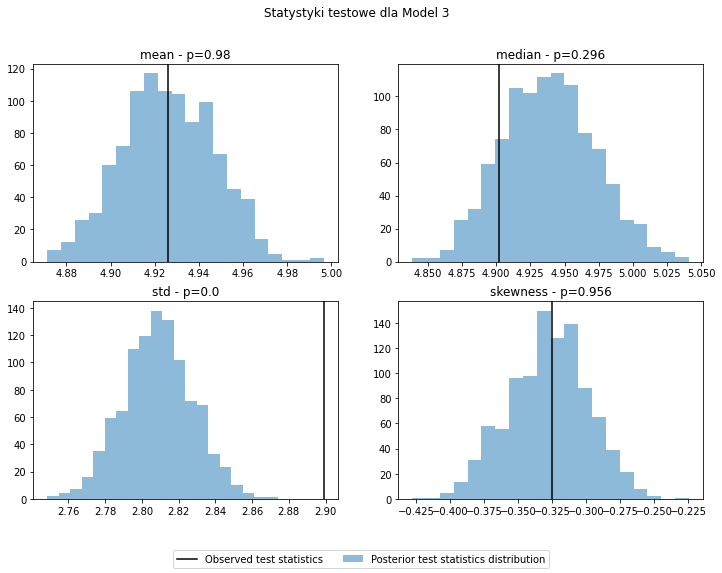

In [14]:
from src.vis import plot_posterior_test_statistics

plot_posterior_test_statistics(
    model_3.predict(x_3),
    data[1],
    test_statistics,
    title='Statystyki testowe dla Model 3'
)

### Komentarz

- Graficzne porównanie rozkładu posterior predictive oraz zastosowanie statystyk testowych mozemy zrobic z podzialem na grupy, tj. jezeli wystepuja zmienne kategoryczne (ujete w modelu badz nie), to mozemy analizowac rozklad predykcyjny dla kazdej z kategorii osobno
- W przedstawionych przykladach wykorzystano ten sam zbiór danych do "treningu" i "testowania". Z Bayesowskiego punktu widzenia nie jest to naduzycie, ale w praktyce zawsze rozsadnie jest zostawic zbiór testowy. Jego wykorzystanie w opisanych procedurach jest bezposrednie.

# Ewaluacja modelu
## Probability Integral Transform

### Marginal (Pointwise) Posterior Predictive Checks

W dotychczasowych analizach zajmowalismy sie sprawdzaniem modelu z perspektywy calego zbioru danych. Moze sie jednak okazac, ze w zbiorze wystepuja obserwacje, ktore w jakis sposób odstaja od pozostalych. Moze to wynikac z bledow pomiaru, ale rowniez mozliwe jest ze proces generujacy jest bardziej skomplikowany niz podejrzewalismy i byc moze opiera sie o pewne zmienne dla nas ukryte. Dlatego nie usuwamy rekordów nietypowych jezeli nie mamy prawa podejrzewac, ze powstaly jako blad. Mozemy tez swiadomie zrezygnowac z modelowania pewnych aspektow procesu generujacego, ale takie podejscie jest malo uzyteczne w praktyce.

W swiecie Bayesowskim do identyfikacji nietypowych obserwacji mozemy wykorzystac *leave-one-out cross-validation predictive density*
$$ p(y_i|x_i, \mathcal{D}_{-i}) = \int p(y_i|\pmb{\theta}, x_i) p(\pmb{\theta}|X_{-i}, y_{-i}) d \pmb{\theta},$$
gdzie przez $X_{-i}$ rozumiemy zbiór pozbawiony $i$-tej próbki.

### Probability integral transform

Zalozmy, ze pewna ciagla zmienna losowa $X$ ma rozklad o dystrybuancie $F_X$. Wtedy zmienna
$$ Y = F_X(X) $$
ma rozklad jednostajny na przedziale $[0, 1]$.

Własnosc jest zachowana gdy dodamy warunkowanie.

To samo mozemy udowodnic w druga strone, tj $Y$ jednostajne -> $f(Y)$ ma dystrybuante $f(x)$ gdy funkcja spelnia odpowiednie warunki.

### Probability integral transform - zastosowanie

Zastosowanie Probability integral transform do ewaluacji modelu ma charakter dowodu wprost:
1. Załózmy, ze model dobrze opisuje kazdy z punktów danych, zatem *leave-one-out cross-validation predictive CUMULATIVE density* dla kazdej probki jest prawdziwa dystrybuanta i mozemy zastosowac transformacje.
2. Dla kazdego $i$ liczymy $p_i = P(\tilde{y}_i \leqslant y_i | x_i, \mathcal{D}_{-i}) = \int_{-\infty}^{y_i} p(z|x_i, \mathcal{D}_{-i}) dz$ - mozemy to zrobic wykorzystujac Monte Carlo, postac analityczna albo calkowanie numeryczne funkcji gestosci
3. Wyswiatlamy rozklad $p_i$ - jezeli jest bliski standardowemu rozkladowi jednostajnemu, to zalozenie bylo prawdziwe. W przeciwnym wypadku nalezy je odrzucic.

Uwaga:
- pracujac na skonczonej probce, nawet przy poprawnosci zalozenia nie otrzymamy perfekcyjnego rozkladu
- metoda nie powie nam, czy problem wystepuje dla jednej, czy wielu (wszystkich) probek
- procedura wymaga $N$-krotnego dopasowywania modelu - istnieje dobra aproksymacja Pareto Smoothed Importance Sampling (PSIS) (poza spektrum tego wykladu)

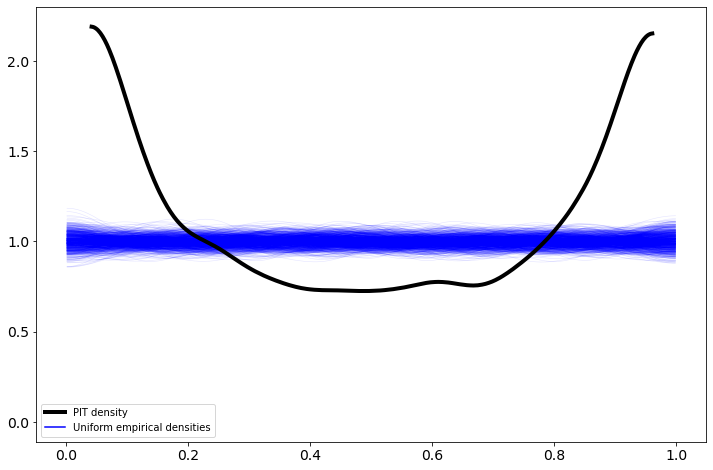

In [15]:
from src.vis import plot_pit

plot_pit(
    model_1,
    x_1,
    data[1]
)

### Interpretacja wyników

- PIT density skoncentrowana blisko 0 i 1 - under-dispersed model, czyli rozklad predykcyjny jest zbyt waski dla obserwowanych danych
- PIT density skoncentrowana wokół 0.5 - over-dispersed model, czyli rozklad predykcyjny jest zbyt szeroki dla obserwowanych danych

Uwaga dla BLR z EM dla $\alpha$ i $\lambda$ - rozsadnym wydaje sie wybrac wartosci parametrow precision z modelu na pelnych danych i stosowac zwyczajny, sprzezony BLR do PIT

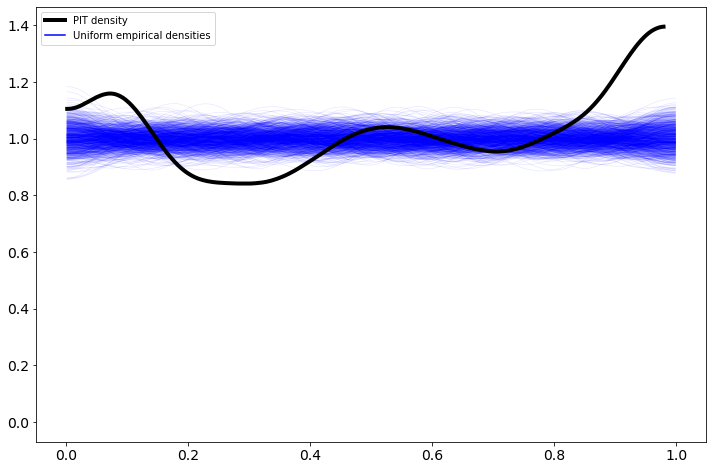

In [16]:
from src.vis import plot_pit

plot_pit(
    model_2,
    x_2,
    data[1]
)

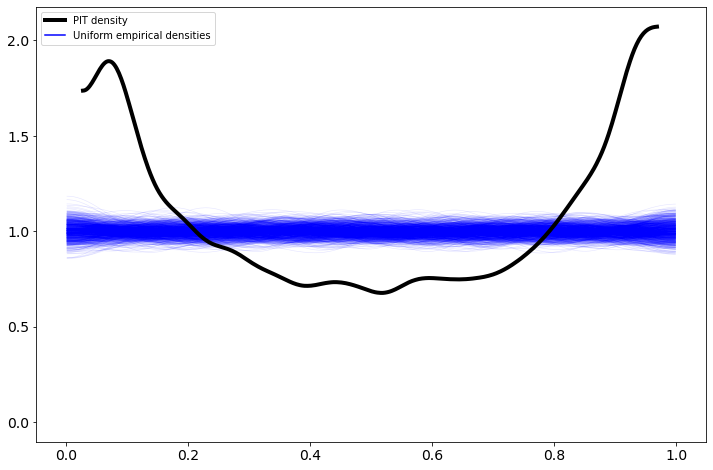

In [17]:
from src.vis import plot_pit

plot_pit(
    model_3,
    x_3,
    data[1]
)

# Porównywanie modeli
## Bayes factors

### Który model wybrać?

Rozwazania w ramach tego wykladu rozpoczelismy od pytania **"Czy model jest poprawny?"**. Nastepnie wyprowadzilismy rozklad posterior modelu i stwierdzilismy, ze nie potrafimy go obliczyc:

$$ P(M|\mathcal{D}, I) = \frac{p(\mathcal{D}|M,I) P(M|I)}{p(\mathcal{D}|I)} $$

Wysilek nie poszedl jednak na marne. Musimy jednak przeformuowac pytanie na **"Który model jest lepszy?**

### Bayes factors

Rozwazmy sytuacje ze posiadamy dwa modele $M_1$ i $M_2$. Chcac je porownac mozemy spojrzec na ich *posterior odds ratio*

$$ \frac{P(M_1|\mathcal{D}, I)}{P(M_2|\mathcal{D}, I)} = \frac{p(\mathcal{D}|M_1,I) P(M_1|I) / p(\mathcal{D}|I)}{p(\mathcal{D}|M_2,I) P(M_2|I) / p(\mathcal{D}|I)} = \left(\frac{p(\mathcal{D}|M_1,I)}{p(\mathcal{D}|M_2,I)} \right) \left(\frac{P(M_1|I)}{P(M_2|I)} \right) $$

W ten sposób udało sie pozbyc problematycznego $p(\mathcal{D}|I)$ i wydzielic dwa czynniki:
- prior ods ratio
$$\frac{P(M_1|I)}{P(M_2|I)}$$
- **Bayes factor**
$$\frac{p(\mathcal{D}|M_1,I)}{p(\mathcal{D}|M_2,I)}$$

### Bayes factors cd

Bayes factor mowi o tym, jak nasza ocena porownania modeli zmienia sie w obliczu zobaczenia probki danych $\mathcal{D}$.

Jest to przydatne narzedzie, poniewaz w sytuacji dwoch obserwatorow o roznym background information nie beda sie oni zgadzac apriori, ale zaobserwuja ta sama zmiane w przekonaniu na bazie danych
$$ \frac{P(M_1|I)}{P(M_2|I)} \neq \frac{P(M_1|I')}{P(M_2|I')} $$

$$ \frac{p(\mathcal{D}|M_1,I)}{p(\mathcal{D}|M_2,I)} = \frac{p(\mathcal{D}|M_1,I')}{p(\mathcal{D}|M_2,I')} $$

Bayes factor bedzie preferowal model o mniejszej zlozonosci - po wiecej informacji zajrzyj do [Part Two: Bayesian Model Evaluation](https://ccrgpages.rit.edu/~whelan/courses/2017_1sp_STAT_489/notes_models.pdf).

In [18]:
from src.stats import bf_model_comparison

models_data = [
        (model_1, x_1),
        (model_2, x_2),
        (model_3, x_3),
    ]

bf_model_comparison(models_data, data[1])

/lecture/lecture/src/stats.py:18: RuntimeWarning: invalid value encountered in double_scalars
  models_data[j][0].likelihood(models_data[j][1], y) /


,M_1,M_2,M_3
index,,,
M_1,1.0,NaN,NaN
M_2,NaN,1.0,NaN
M_3,NaN,NaN,1.0


# Porównywanie modeli
## Expected Log Predictive Density

### Expected Log Predictive Density

W ocenianiu modelu nadchodzi moment gdy chcemy ocenic jak dokladnie *on average* zadziala on w zadaniu predykcji na nowych danych pochodzacych z procesu generujacego. Mówi o tym **Expected Log Predictive Density** - *expected log pointwise predictive density for a new dataset with $n$ data points*:

$$ \mathrm{elpd} = \sum_{i=1}^n \int p_{gen}(\tilde{y}_i) \log p(\tilde{y}_i|\mathcal{D}, M, I) d \tilde{y}_i,$$
gdzie $p_{gen}(\tilde{y}_i)$ to proces generujacy dane.

Ale my nie znamy $p_{gen}(\tilde{y}_i)$! Inaczej mielibysmy gotowy model. Musimy zatem zaproponowac estymator $ \mathrm{elpd}$.

$$ \mathrm{elpd}_{\mathrm{LLO}} = \sum_{i=1}^n \log p(y_i|x_i, \mathcal{D}_{-i}),$$
gdzie skrót LLO oznacza *Leave-one-out cross-validation*.

Szersze omówienie zagadnienia mozna znalezc w publikacji [Vehtari, A., Gelman, A., and Gabry, J. (2017a). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing. 27(5), 1413--1432. doi:10.1007/s11222-016-9696-4](https://arxiv.org/abs/1507.04544). Autorzy napisali pakiet w R (oraz czesc funkcjonalnosci w bibliotece Stan w Pythonie), w ktorym zaimplementowana jest wiekszosc omawianych na tym wykladzie narzedzi. Odnosniki znajduja sie w publikacji.

In [19]:
from src.stats import elpd_loo

print('Model 1 ELPD_llo =', elpd_loo(model_1, x_1, data[1]))
print('Model 2 ELPD_llo =', elpd_loo(model_2, x_2, data[1]))
print('Model 3 ELPD_llo =', elpd_loo(model_3, x_3, data[1]))

Model 1 ELPD_llo = -8937.39177963321
Model 2 ELPD_llo = -11428.343056545189
Model 3 ELPD_llo = -8961.456627487027


Zamiast patrzeć na sumarycznym ELPD każdego modelu z osobna mozna wyciagac skladniki $\mathrm{elpd}_{\mathrm{LLO}}$

$$ \mathrm{elpd}_{\mathrm{LLO},i} = \log p(y_i|x_i, \mathcal{D}_{-i}) $$

dla kazdego z punktów danych i patrzec na ich roznice pomiedzy modelami. W ten sposób dokonujemy porownania modeli z granularnoscia pojedynczego punktu danych.

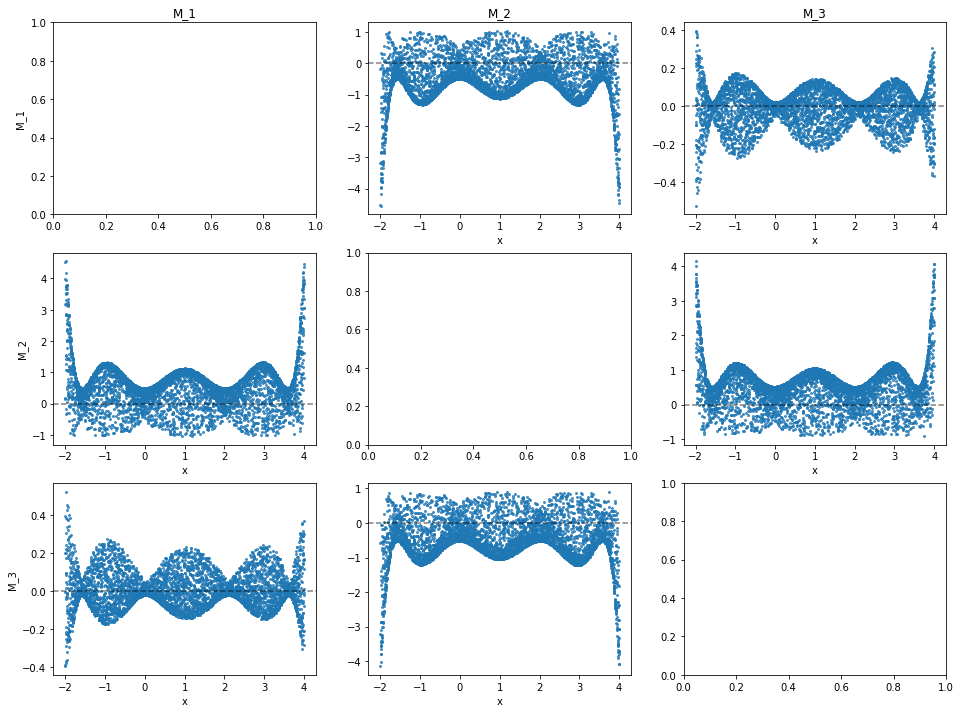

In [20]:
from src.vis import plot_elpd_loo_comparison

plot_elpd_loo_comparison(models_data, data[0], data[1])

### Uwagi końcowe

- Wszystkie opisane tutaj metody sa aplikowalne dla modeli dopasowanych z wykorzytaniem metod przyblizonych (VI, MCMC) poniewaz mozemy w nich wykorzystac metode Monte Carlo. Jedynym miejsce, w ktorym MC sie nie sprawdzi, jest ewaluacja gestosci predykcyjnej modelu (np. przy obliczaniu likelihood modelu), zatem dla estymacji MCMC musimy zastosowac Kernel Density Estimation by otrzymac pdf.

- Omówilismy problem regresji, ale wszystkie metody poza PIT sa aplikowalne dla klasyfikacji - rozklad predykcyjny, to rozklad kategoryczny. Wszedzie gdzie opieramy sie na rozkladzie predykcyjnym sprawa jest oczywista. W przypadku diagnostyki opartej o statystyki testowe nalezy zadbac o dobór odpowiednich statystyk. UWAGA: jezeli na dyskretnym nosniku zmiennej zaleznej wystepuje porzadek liniowy (kazde dwie wartosci sa porownywalne zatem istnie kolejnosc elementow nosnika) to nalezy modelowac ja zmienna losowa dyskretna, ktora posiada CDF (wtedy mozemy stosowac PIT!).